In [22]:
import chess
import os
import chess.gaviota as gaviota
import random
import numpy as np
import itertools
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import permutations
import math

In [23]:
random_state = 93
rng = random.Random(random_state)

In [24]:
gaviota_folder = r"C:\SPEICHER\Bachelor_Thesis\Gaviota"

In [25]:
def get_row_col(pos: int):
    """Convert square index (0–63) to (row, col), flipping row so White is at the bottom."""
    return 7 - (pos // 8), pos % 8 

def encode_position(board: chess.Board, additional_pieces: list) -> np.ndarray:
    # additional_pieces e.g. [(chess.ROOK, chess.WHITE), (chess.PAWN, chess.BLACK)]
   
    # Fixed 6 channels: King (0), Queen (1), Rook (2), Bishop (3), Knight (4), Pawn (5)
    representation = np.zeros((6, 8, 8), dtype=np.int8)

    # White King → Channel 0
    white_king_pos = board.king(chess.WHITE)
    representation[0,*get_row_col(white_king_pos)] = 1

    # Black King → Channel 1
    black_king_pos = board.king(chess.BLACK)
    representation[1,*get_row_col(black_king_pos)] = -1 

    # Map piece types to their fixed channels
    piece_to_channel = {
        chess.QUEEN: 1,
        chess.ROOK: 2,
        chess.BISHOP: 3,
        chess.KNIGHT: 4,
        chess.PAWN: 5
    }

    # Place additional pieces in their designated channels
    for piece_type, color in additional_pieces:
        if piece_type in piece_to_channel:
            channel = piece_to_channel[piece_type]
            squares = board.pieces(piece_type, color)
            for square in squares:
                representation[channel, *get_row_col(square)] = 1 if color == chess.WHITE else -1

    return representation

In [26]:
def create_all_5piece_endgame_data(max_positions: int = 1_000_000):
    """
    Generate random 5-piece endgame positions with DTM values using reservoir sampling.

    Args:
        max_positions (int): Maximum number of positions to generate (default: 1,000,000).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Encoded positions (shape: (max_positions, channels, 8, 8), dtype: int8)
                                      and DTM values (shape: (max_positions,), dtype: float32).
    """
    tb = chess.gaviota.PythonTablebase()
    tb.add_directory(gaviota_folder)

    encoded_positions = []
    dtm_values = []
    seen_positions = 0
    rng = random.Random()  # For reproducible random sampling

    # Define all possible piece types (excluding kings)
    piece_types = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]
    
    # Generate all possible 5-piece endgame configurations
    all_configs = []
    for num_additional in range(1, 4):  # 1 to 3 additional pieces (3+2 kings = 5 pieces max)
        for pieces in itertools.combinations_with_replacement(piece_types, num_additional):
            for color_combo in itertools.product([chess.WHITE, chess.BLACK], repeat=num_additional):
                all_configs.append((list(pieces), list(color_combo)))

    # Shuffle configurations to process them randomly
    random.shuffle(all_configs)

    # Generate all 64 squares and shuffle them
    squares = list(itertools.product(range(8), repeat=2))
    random.shuffle(squares)

    for additional_pieces, colors in all_configs:
        if len(encoded_positions) >= max_positions:
            break

        num_additional = len(additional_pieces)
        pawnExists = chess.PAWN in additional_pieces
        
        # Define reduced white king positions (Symmetry)
        if pawnExists:
            valid_wk_positions = [(r, c) for r in range(8) for c in range(4, 8)]
        else:
            valid_wk_positions = [(r, c) for r in range(0, 4) for c in range(4, 8) if r + c <= 7]
        random.shuffle(valid_wk_positions)

        for wk in valid_wk_positions:
            wk_sum = wk[0] + wk[1]
            for bk in squares:
                # Ensure kings are not adjacent
                if abs(wk[0] - bk[0]) < 2 and abs(wk[1] - bk[1]) < 2:
                    continue
                
                # Ensure the Black King is on the left side of the diagonal if the White King is on the diagonal
                bk_sum = bk[0] + bk[1]
                if not pawnExists and (wk_sum == 7 and bk_sum > 7):
                    continue

                # Check if both kings are on the diagonal
                kings_on_diag = wk_sum == 7 and bk_sum == 7
                filtered_squares = [sq for sq in squares if sq not in (wk, bk)]
                
                # Shuffle piece positions to randomize placement
                piece_positions = list(itertools.permutations(filtered_squares, num_additional))
                random.shuffle(piece_positions)

                for piece_position in piece_positions:
                    seen_positions += 1

                    # Reservoir sampling: decide whether to include this position
                    if len(encoded_positions) < max_positions:
                        store_index = len(encoded_positions)
                    else:
                        # Randomly decide to replace an existing position
                        store_index = rng.randint(0, seen_positions - 1)
                        if store_index >= max_positions:
                            continue

                    if seen_positions % 100000 == 0:
                        print(f"Generated {seen_positions} positions...")

                    invalid = False
                    board = chess.Board.empty()
                    board.turn = chess.WHITE
                    board.set_piece_at(chess.square(wk[1], wk[0]), chess.Piece(chess.KING, chess.WHITE))
                    board.set_piece_at(chess.square(bk[1], bk[0]), chess.Piece(chess.KING, chess.BLACK))

                    # Place additional pieces on the board
                    for idx, (piece_type, pos) in enumerate(zip(additional_pieces, piece_position)):
                        # Invalid pawn placement check
                        if piece_type == chess.PAWN and (pos[0] in (0, 7)):
                            invalid = True
                            break
                        board.set_piece_at(chess.square(pos[1], pos[0]), chess.Piece(piece_type, colors[idx]))
                    
                    if invalid:
                        continue

                    # Check if the position is valid
                    try:
                        dtm = tb.probe_dtm(board)
                        if dtm != 0:
                            dtm = 1 / dtm

                        encoded_pos = encode_position(board, list(zip(additional_pieces, colors)))
                        if store_index == len(encoded_positions):
                            encoded_positions.append(encoded_pos)
                            dtm_values.append(dtm)
                        else:
                            encoded_positions[store_index] = encoded_pos
                            dtm_values[store_index] = dtm

                    except chess.gaviota.MissingTableError:
                        continue

    encoded_positions_array = np.array(encoded_positions, dtype=np.int8)
    dtm_values_array = np.array(dtm_values, dtype=np.float32)
    
    return encoded_positions_array, dtm_values_array

In [ ]:
def create_pairs(encoded_positions, dtm_values, max_pairs=500_000):
    position_pairs = []
    labels = []
    seen_pairs = set()  # To store the hash of pairs we've already added

    num_positions = len(dtm_values)

    while len(position_pairs) < max_pairs:
        # Randomly select two different indices
        idx1 = rng.randint(0, num_positions - 1)
        idx2 = rng.randint(0, num_positions - 1)
 
        if idx1 == idx2:
            continue

        pair_indices = (idx1, idx2)
        if pair_indices in seen_pairs:
            continue

        seen_pairs.add(pair_indices)
            
        dtm1, dtm2 = dtm_values[idx1], dtm_values[idx2]
        # 1 = pos1 better, 0 = roughly equal, 2 = pos2 better 
        label = 1 if dtm1 > dtm2 else 2 if dtm1 < dtm2 else 0
        
        # Add the pair and label
        position_pairs.append(pair_indices)
        labels.append(label)
   
    # Convert to numpy arrays for training
    idx1s, idx2s = zip(*position_pairs)
    X1 = encoded_positions[list(idx1s)].astype(np.int8)
    X2 = encoded_positions[list(idx2s)].astype(np.int8)
    Y = np.array(labels, dtype=np.int8)
    return X1, X2, Y

In [28]:
results = {}

# Create, shuffle and save position data
positions, dtm_values = create_all_5piece_endgame_data()
print(dtm_values.shape[0], "Samples generated and shuffled")

indices = np.arange(len(dtm_values))
np.random.shuffle(indices)
positions = positions[indices]
dtm_values = dtm_values[indices]

positions_train_val, positions_test, dtm_values_train_val, dtm_values_test = train_test_split(positions, dtm_values, test_size=0.1, random_state=random_state)

np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\DataBase\Mixed_position_train_val.npz", X=positions_train_val, y=dtm_values_train_val)
print(f"Data saved to Mixed_position_train_val.npz")
np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\DataBase\Mixed_position_test.npz", X=positions_test, y=dtm_values_test)
print(f"Data saved to Mixed_position_test.npz")

# Create, shuffle and save pairs
X1, X2, y = create_pairs(positions, dtm_values)
print(y.shape[0], "Pairs generated and shuffled")

indices = np.arange(len(y))
np.random.shuffle(indices)
X1 = X1[indices]
X2 = X2[indices]
y = y[indices]

X1_train_val, X1_test, X2_train_val, X2_test, y_train_val, y_test = train_test_split(X1, X2, y, test_size=0.1, random_state=random_state)

np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\Mixed_pairs_train_val.npz", X1=X1_train_val, X2=X2_train_val, y=y_train_val)
print(f"Data saved to Mixed_pairs_train_val.npz")
np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\Mixed_pairs_test.npz", X1=X1_test, X2=X2_test, y=y_test)
print(f"Data saved to Mixed_pairs_test.npz")

Generated 100000 positions...
Generated 200000 positions...
Generated 300000 positions...
Generated 400000 positions...
Generated 500000 positions...
Generated 600000 positions...
Generated 700000 positions...
Generated 800000 positions...
Generated 900000 positions...
Generated 1000000 positions...
Generated 1100000 positions...
Generated 1200000 positions...
Generated 1300000 positions...
Generated 1400000 positions...
Generated 1500000 positions...
Generated 1600000 positions...
Generated 1800000 positions...
Generated 1900000 positions...
Generated 2000000 positions...
Generated 2100000 positions...
Generated 3100000 positions...
Generated 3400000 positions...
Generated 3500000 positions...
Generated 4400000 positions...
Generated 4500000 positions...
Generated 4800000 positions...
Generated 5000000 positions...
Generated 5200000 positions...
Generated 5300000 positions...
Generated 5400000 positions...
Generated 6100000 positions...
Generated 6700000 positions...
Generated 7100000

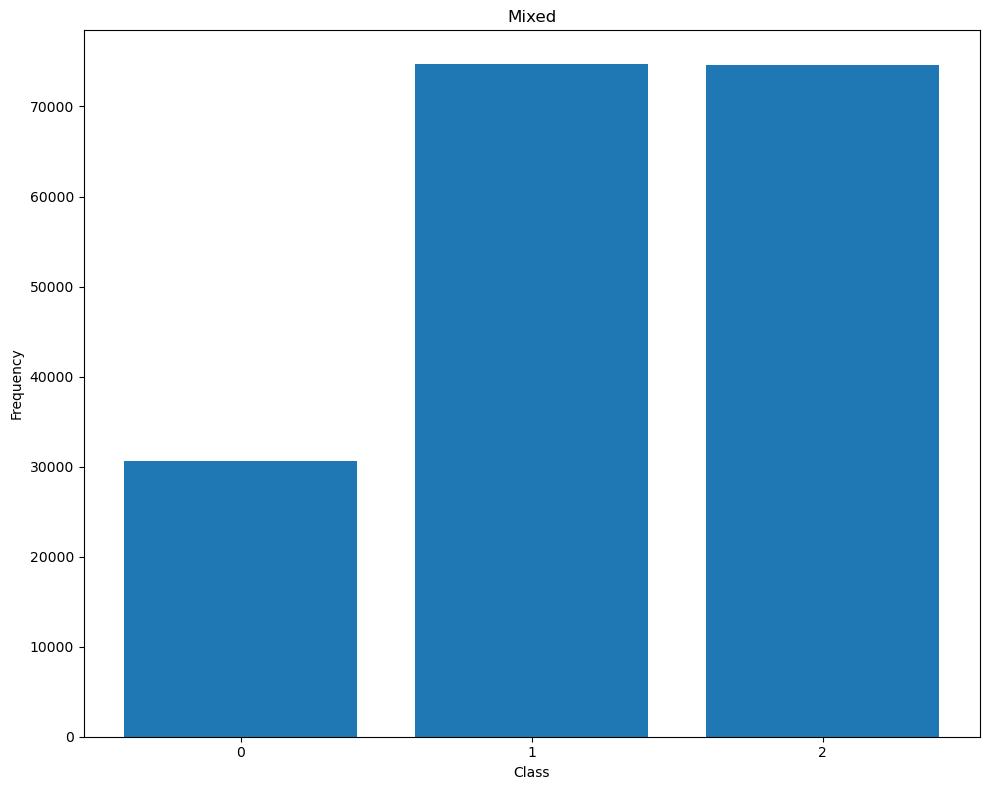

In [29]:
# Store counts for later plotting
unique, counts = np.unique(y_train_val, return_counts=True)

fig, axes = plt.subplots(figsize=(10, 8))

axes.bar(unique, counts)
axes.set_xticks(unique)
axes.set_title("Mixed")
axes.set_xlabel("Class")
axes.set_ylabel("Frequency")

plt.tight_layout()
plt.show()